In [1]:
# Description:
#             Reinforcement Learning Exercise - Q-Learning Trading Game.
# Date:
#             15-May-2020, Initial build
#             08-Jun-2020, reviewed
# Credits:
#            This implementation: Nicholas Jenkins.
#            
#            This Notebook is a worked example based on: 
#            https://github.com/PacktPublishing/Hands-On-Machine-Learning-for-Algorithmic-Trading/blob/master/Chapter21/04_q_learning_for_trading.ipynb
#            By: Stefan Jansen.
#            The Phython code for the Gym TradingEnvironment is based on an example from MIT.
# Strategy : 1. BUY - Invest capital for a long position in the stock
#            2. FLAT - Hold cash only
#            3. Sell Short - take a short position in the stock equal to the amount of capital.
# note: to instlall TradingEnvironment.ph, CD to the TradingEnvironment directory and run the following Pip command:
# pip install -e .

#
# Imports & Settings
#

%matplotlib inline
from pathlib import Path
from collections import deque, namedtuple
from time import time
from random import sample
import numpy as np
from numpy.random import random, randint, seed
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns


import tensorflow.compat.v1 as tf

import gym
from gym.envs.registration import register

In [2]:
sns.set_style('darkgrid')

In [3]:
#from pathlib import Path

#pd.set_option('display.expand_frame_repr', False)

In [4]:
#DATA_STORE = Path('/Users/nicholasjenkins/Documents/TradingEnvironment/data/quandl/wiki/prices/assets.h5')

In [5]:
# convert the downloaded Stock prices to HDF format from CSV format

# df = (pd.read_csv('/Users/nicholasjenkins/Documents/TradingEnvironment/data/wiki_prices.csv',
#                 parse_dates=['date'],
#                 index_col=['date', 'ticker'],
#                 infer_datetime_format=True)
#     .sort_index())

#print(df.info(null_counts=True))
#with pd.HDFStore(DATA_STORE) as store:
#    store.put('/Users/nicholasjenkins/Documents/TradingEnvironment/data/quandl/wiki/prices', df)

In [6]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:05.2f}'.format(m, s)

In [7]:
def track_results(episode, episode_nav,
                  market_nav, ratio,
                  total,
                  epsilon):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)

    print('{:>4d} | NAV: {:>5.3f} | Market NAV: {:>5.3f} | Delta: {:4.0f} | {} | '
          'eps: {:>6.3f}'.format(episode,
                                  episode_nav,
                                  market_nav,
                                  ratio,
                                  format_time(total),
                                  epsilon))

In [8]:
#
# Register the Trading environment from Gym
#

register(
    id='trading-v0',
    entry_point='trading_env:TradingEnvironment',
    max_episode_steps=10000
)

In [9]:
#
#instantiate the trading environment
#

trading_environment = gym.make('trading-v0')


INFO:trading_env:trading_env logger started.
INFO:trading_env:in preprocess()...
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [10]:
#trading_environment.env.trading_cost_bps = 1e-3
#trading_environment.env.time_cost_bps = 1e-4
#trading_environment.env.ticker = 'AAPL'
#trading_environment.seed(42)

In [11]:
#
#get enviroment parameters
#

state_dim = trading_environment.observation_space.shape[0]  # number of dimensions in state
n_actions = trading_environment.action_space.n  # number of actions
max_episode_steps = trading_environment.spec.max_episode_steps  # max number of steps per episode

In [12]:
# Define hyperparameters

gamma=.99,  # discount factor
tau=100  # target network update frequency

In [13]:
#define Neural Network parameters

layers=(256,) * 3  # units per layer
learning_rate=5e-5  # learning rate
l2_reg=1e-6  # L2 regularization

In [14]:
# experience reply

replay_capacity=int(1e6)
minibatch_size=5


In [15]:
# greedy policy

epsilon_start=1.0
epsilon_end=0.1
epsilon_linear_steps=5e5
epsilon_exp_decay=.9999

In [16]:
# create nueral network

tf.disable_v2_behavior()

tf.reset_default_graph()

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [17]:
# Dense Layers
# The create_network function generates the three dense layers that can be trained and/or reused 
# as required by the Q network and its slower-moving target network:

def create_network(s, layers, trainable, reuse, n_actions=4):
    """Generate Q and target network with same structure"""
    for layer, units in enumerate(layers):
        x = tf.layers.dense(inputs=s if layer == 0 else x,
                            units=units,
                            activation=tf.nn.relu,
                            trainable=trainable,
                            reuse=reuse,
                            name='dense_{}'.format(layer))
    return tf.squeeze(tf.layers.dense(inputs=x,
                                      units=n_actions,
                                      trainable=trainable,
                                      reuse=reuse,
                                      name='output'))

In [18]:
state = tf.placeholder(dtype=tf.float32, shape=[None, state_dim])  # input to Q network
next_state = tf.placeholder(dtype=tf.float32, shape=[None, state_dim])  # input to target network
action = tf.placeholder(dtype=tf.int32, shape=[None])  # action indices (indices of Q network output)
reward = tf.placeholder(dtype=tf.float32, shape=[None])  # rewards for target computation
not_done = tf.placeholder(dtype=tf.float32, shape=[None])  # indicators for target computation

In [19]:
# Episode Counter
# We add a variable to keep track of episodes:
    
episode_count = tf.Variable(0.0, trainable=False, name='episode_count')
add_episode = episode_count.assign_add(1)

In [20]:

# Deep Q Networks
# We will create two DQNs to predict q values for the current 
# and next state, where we hold the weights for the second network that's fixed when predicting the next state:

with tf.variable_scope('Q_Network'):
    # Q network applied to current observation
    q_action_values = create_network(state,
                                     layers=layers,
                                     trainable=True,
                                     reuse=False)

    # Q network applied to next_observation
    next_q_action_values = tf.stop_gradient(create_network(next_state,
                                                           layers=layers,
                                                           trainable=False,
                                                           reuse=True))

Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


In [21]:
# Slow-Moving Target Network
# In addition, we will create the target network that we update every tau periods:

with tf.variable_scope('Target_Network', reuse=False):
    target_action_values = tf.stop_gradient(create_network(next_state,
                                                           layers=layers,
                                                           trainable=False,
                                                           reuse=False))

In [22]:
# Collect Variables and Operations
# To build TensorFlow's computational graph, we need to collect the relevant variables and operations:

q_network_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Q_Network')
target_network_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Target_Network')

# update target network weights
update_target_ops = []
for i, target_variable in enumerate(target_network_variables):
    update_target_op = target_variable.assign(q_network_variables[i])
    update_target_ops.append(update_target_op)
update_target_op = tf.group(*update_target_ops, name='update_target')


In [23]:

# Compute Q-Learning updates
# The target, yi, and the predicted q value is computed as follows:

# Q target calculation 
targets = reward + not_done * gamma * tf.gather_nd(target_action_values, tf.stack(
                (tf.range(minibatch_size), tf.cast(tf.argmax(next_q_action_values, axis=1), tf.int32)), axis=1))


# Estimated Q values for (s,a) from experience replay
predicted_q_value = tf.gather_nd(q_action_values,
                                 tf.stack((tf.range(minibatch_size),
                                           action), axis=1))

In [24]:

# Compute Loss Function
# Finally, the TD loss function that's used for stochastic gradient descent is the mean squared error (MSE) 
# between the target and prediction:

losses = tf.squared_difference(targets, predicted_q_value)
loss = tf.reduce_mean(losses)
loss += tf.add_n([tf.nn.l2_loss(var) for var in q_network_variables if 'bias' not in var.name]) * l2_reg * 0.5

In [25]:
summaries = tf.summary.merge([
    tf.summary.scalar('episode', episode_count),
    tf.summary.scalar('loss', loss),
    tf.summary.scalar('max_q_value', tf.reduce_max(predicted_q_value)),
    tf.summary.histogram('loss_hist', losses),
    tf.summary.histogram('q_values', predicted_q_value)])

In [26]:
# Use Adam Optimizer

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss,
                                                          global_step=tf.train.create_global_step())

In [27]:
# Initialize TensorFlow session

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [28]:
# set experiement 
# set parameters

total_steps, max_episodes = 0, 10000
experience = deque(maxlen=replay_capacity)
episode_time, navs, market_navs,diffs, episode_eps = [], [], [], [],[]

In [29]:
# Initialize variables

experience = deque(maxlen=replay_capacity)
episode_time, episode_steps, episode_rewards, episode_eps = [], [], [], []

In [30]:
epsilon = epsilon_start
epsilon_linear_step = (epsilon_start - epsilon_end) / epsilon_linear_steps

In [31]:
#train agent

for episode in range(max_episodes):
    episode_start = time()
    episode_reward = 0
    episode_eps.append(epsilon)

    # Initial state
    this_observation = trading_environment.reset()
    for episode_step in range(max_episode_steps):

        # choose action according to epsilon-greedy policy wrt Q

        if random() < epsilon:
            src = 'eps'
            selected_action = randint(n_actions)
        else:
            src = 'q'
            q_s = sess.run(q_action_values,
                           feed_dict={state: this_observation[None]})
            selected_action = np.argmax(q_s)

        next_observation, step_reward, done, _ = trading_environment.step(selected_action)
        episode_reward += step_reward

        # add to replay buffer
        experience.append((this_observation,
                           selected_action,
                           step_reward,
                           next_observation,
                           0.0 if done else 1.0))

        # update the target weights
        if total_steps % tau == 0:
            _ = sess.run(update_target_op)

        # update weights using minibatch of (s,a,r,s') samples from experience
        if len(experience) >= minibatch_size:
            minibatch = map(np.array, zip(
                *sample(experience, minibatch_size)))
            states_batch, action_batch, reward_batch, next_states_batch, done_batch = minibatch

            # do a train_op with required inputs
            feed_dict = {
                state: states_batch,
                action: action_batch,
                reward: reward_batch,
                next_state: next_states_batch,
                not_done: done_batch}
            _ = sess.run([train_op],
                         feed_dict=feed_dict)

        this_observation = next_observation
        total_steps += 1

        # linearly decay epsilon from epsilon_start to epsilon_end for epsilon_linear_steps
        if total_steps < epsilon_linear_steps:
            epsilon -= epsilon_linear_step
        # then exponentially decay every episode
        elif done:
            epsilon *= epsilon_exp_decay

        if done:
            # Increment episode counter
            episode_, _ = sess.run([episode_count, add_episode])
            break

    episode_time.append(time()-episode_start)
    result = trading_environment.env.sim.result()
    final = result.iloc[-1]

    nav = final.nav * (1 + final.strategy_return)
    navs.append(nav)

    market_nav = final.market_nav
    market_navs.append(market_nav)

    diff = nav - market_nav
    diffs.append(diff)
    if episode % 250 == 0:
        track_results(episode,
                      np.mean(navs[-100:]),
                      np.mean(market_navs[-100:]),
                      np.sum([s > 0 for s in diffs[-100:]]),
                      sum(episode_time),
                      epsilon)

    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break

trading_environment.close()

   0 | NAV: 0.637 | Market NAV: 0.531 | Delta:    1 | 00:00.47 | eps:  1.000
 250 | NAV: 0.783 | Market NAV: 1.220 | Delta:    8 | 01:25.71 | eps:  0.886
 500 | NAV: 0.797 | Market NAV: 1.175 | Delta:   15 | 02:56.54 | eps:  0.773
 750 | NAV: 0.787 | Market NAV: 1.130 | Delta:   14 | 04:33.28 | eps:  0.659
1000 | NAV: 0.816 | Market NAV: 1.164 | Delta:   10 | 06:15.10 | eps:  0.546
1250 | NAV: 0.799 | Market NAV: 1.212 | Delta:   11 | 08:02.93 | eps:  0.433
1500 | NAV: 0.946 | Market NAV: 1.168 | Delta:   18 | 09:56.19 | eps:  0.319
1750 | NAV: 0.948 | Market NAV: 1.172 | Delta:   21 | 11:54.92 | eps:  0.206
2000 | NAV: 1.006 | Market NAV: 1.098 | Delta:   33 | 13:59.27 | eps:  0.100
2250 | NAV: 1.234 | Market NAV: 1.192 | Delta:   42 | 16:08.02 | eps:  0.097
2500 | NAV: 1.289 | Market NAV: 1.202 | Delta:   52 | 18:20.81 | eps:  0.095
2750 | NAV: 1.261 | Market NAV: 1.209 | Delta:   46 | 20:37.05 | eps:  0.093
3000 | NAV: 1.307 | Market NAV: 1.207 | Delta:   45 | 22:57.84 | eps:  0.090

In [32]:
#store results

results = pd.DataFrame({'episode': list(range(1, episode + 2)),
                        'nav': navs,
                        'market_nav': market_navs,
                        'outperform': diffs})
print(results)
fn = '/Users/nicholasjenkins/Documents/TradingEnvironment/data/trading_agent_result_no_cost.csv'
results.to_csv(fn, index=False)

      episode       nav  market_nav  outperform
0           1  0.636558    0.531126    0.105432
1           2  0.735221    1.034361   -0.299140
2           3  0.696142    1.078055   -0.381914
3           4  0.781607    1.252635   -0.471028
4           5  0.510654    1.151485   -0.640831
...       ...       ...         ...         ...
9995     9996  1.625032    1.290427    0.334605
9996     9997  1.539598    1.264290    0.275308
9997     9998  0.501052    0.651951   -0.150899
9998     9999  1.154552    0.992205    0.162347
9999    10000  2.237173    1.350815    0.886359

[10000 rows x 4 columns]


In [33]:
results = pd.read_csv('/Users/nicholasjenkins/Documents/TradingEnvironment/data/trading_agent_result_no_cost.csv')
results.columns = ['episode', 'nav', 'market_nav', 'diffs']
results = results.set_index('episode')
results['Strategy Wins (%)'] = (results.diffs > 0).rolling(100).sum()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nav                10000 non-null  float64
 1   market_nav         10000 non-null  float64
 2   diffs              10000 non-null  float64
 3   Strategy Wins (%)  9901 non-null   float64
dtypes: float64(4)
memory usage: 390.6 KB


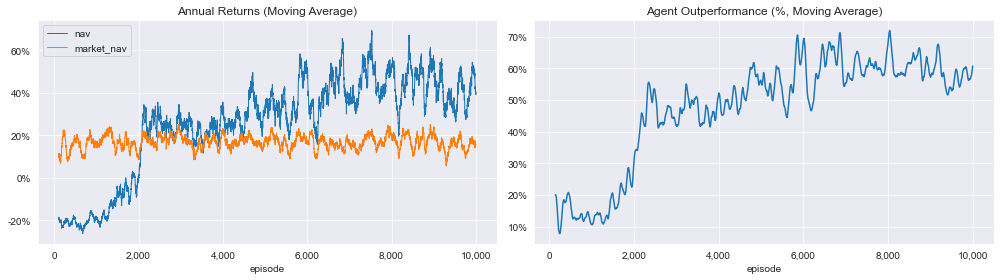

In [34]:
# Evaluate and display results

# The following diagram shows the rolling average of agent and market returns over 100 periods on the left, 
# and the share of the last 100 periods the agent outperformed the market on the right. 
# It uses AAPL stock data for which there are some 9,000 daily price and volume observations. 
# Training stopped after 14,000 trading periods when the agent beat the market 10 consecutive times.
# It shows how the agent's performance improves significantly while exploring at a higher rate 
# over the first ~3,000 periods (that is, years) and approaches a level where it outperforms the market 
# around 40 percent of the time, despite transaction costs. In a few instances, it beats the market about 
# half the time out of 100 periods:

fig, axes = plt.subplots(ncols=2, figsize=(14,4))
(results[['nav', 'market_nav']]
 .sub(1)
 .rolling(100)
 .mean()
 .plot(ax=axes[0], 
       title='Annual Returns (Moving Average)', lw=1))
results['Strategy Wins (%)'].div(100).rolling(50).mean().plot(ax=axes[1], title='Agent Outperformance (%, Moving Average)');
for ax in axes:
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
fig.tight_layout()
# fig.savefig('figures/trading_agent', dpi=300)